<a href="https://colab.research.google.com/github/Hamid-Mofidi/Diffusion-Models/blob/main/DDPM_Paper/DDPM_coding_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The diffusion Model

We first go through the the paper step by step to define the values needed for setting up the forward process. Then we'll clean up the code to "def"ine a forward diffusion funciton.

**Paper: 2020_(DDPM) Denoising Diffusion Probabilistic Models(UC Berkely)**

mean = sqrt(a_hat_t) * x_0

varience = sqrt(1 - a_hat_t) * random noise

In [1]:
import torch

x0    = torch.randn(2,3,32,32)  # batchsize =2, there are 3 channels containing 32x32 matrices (4D)
betas = torch.tensor([0.05, 0.1, 0.15, 0.2, 0.25])
t     = torch.tensor([1,3])  # 1D tensor with two elements corresponding to the batch size of x0 which is 2
# betas  --> amount of noise that are being applied at every timestep of the diffusion process
# alphas --> 1 - betas --> amount of original images' informaiton that is being preserved after a diffusion process
alphas = 1 - betas
alpha_hat = torch.cumprod(alphas, axis = 0)  # torch.cumprod(alphas, axis=0) returns a tensor
             # of the same shape  as the input tensor, where each element is the cumulative product
             #  of the corresponding elements in the input tensor along the specified axis.

In [2]:
from re import X
result  = alpha_hat.gather(-1,t).reshape(-1,1,1,1)  # takes the one-dimensional tensor "alpha_hat" and an index tensor t,
                # gathers elements of alpha_hat from the specified indices along the last (rightmost) axis,
                # reshapes the result to a 4-dimensional tensor, and assigns the result to a new tensor result.
                # Specifically, alpha_hat.gather(-1, t) will return a tensor with shape (2,)
                # which contains elements alpha_hat[1] and alpha_hat[3].
                # "result" then reshapes the two elements to a 4-dimensional tensor, of shape (2, 1, 1, 1) using
                # the reshape() function to allow it to be used in subsequent computations.
                # the final value of result is a 4-dimensional tensor with two slices along the first dimension, each of which
                # contains a single scalar element from the original tensor alpha_hat, selected based on the indices provided by t.

noise  = torch.rand_like(x0) # torch.rand_like(x0) creates a tensor with the same shape as the input tensor x0,
                             # but with random values generated from a uniform distribution between 0 and 1.
                             # This function is useful when you want to create a tensor with the same shape
                             # as an existing tensor but with random values. It can be used for tasks such as
                             # initializing weights in a neural network or creating a random mask for a tensor.
mean   = result.sqrt() * x0
variance = torch.sqrt(1-result) * noise

x_t = mean + variance

# PIL

PIL stands for Python Imaging Library. It is a popular library in Python for opening, manipulating, and saving many different image file formats. PIL provides a wide range of functions and methods for performing various image processing tasks, such as resizing, cropping, rotating, and applying filters to images.

To convert an image from PIL format to PyTorch format, you can use the `torchvision.transforms.ToTensor()` function from the PyTorch library. Here's an example:

```python
from PIL import Image
import torchvision.transforms as transforms

# Load the image using PIL
pil_image = Image.open('your_image_path.jpg')

# Convert PIL image to PyTorch tensor
transform = transforms.ToTensor()
torch_tensor = transform(pil_image)
```

In this code, you need to replace `'your_image_path.jpg'` with the actual path to your image file. The `Image.open()` function from PIL is used to load the image. Then, the `transforms.ToTensor()` function from the `torchvision.transforms` module is used to convert the PIL image to a PyTorch tensor.

After conversion, `torch_tensor` will be a PyTorch tensor representing the image, which can be used as input for deep learning models or other operations in PyTorch.

Remember to have the `torchvision` package installed in your Python environment to use the `transforms` module.

I hope this helps! Let me know if you have any further questions.

Now, let's clean up the code and define the forward diffusion function:

In [3]:
import torch
import urllib
import PIL
from PIL import Image
import torchvision
from torchvision import transforms
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import math


def forward_diffusion(x0, t, betas = torch.linspace(0.0, 1.0, 5)):
  noise  = torch.rand_like(x0)  # random tensor with values sampled from N(0,1)
  alphas = 1 - betas
  alpha_hat = torch.cumprod(alphas, axis = 0)
  alpha_hat_t = alpha_hat.gather(-1,t).reshape(-1, 1, 1, 1)

  mean   = alpha_hat_t.sqrt() * x0
  variance = torch.sqrt(1-alpha_hat_t) * noise
  return  mean + variance, noise

In [4]:
url = 'https://austerityphoto.co.uk/wp-content/uploads/2022/09/a-photo-of-a-corgi-dog-riding-a-bike-in-times-square.jpg'
filename = 'Corgyriding.jpg'

In [5]:
urllib.request.urlretrieve(url, filename)

('Corgyriding.jpg', <http.client.HTTPMessage at 0x7fe56e834820>)

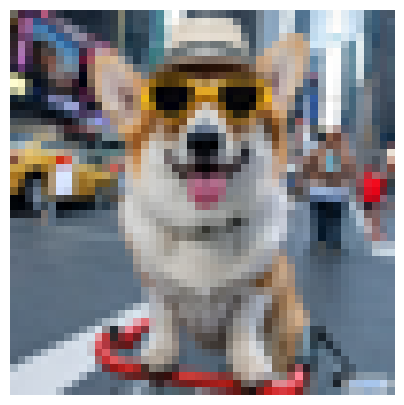

In [34]:
image = Image.open(filename)
# Set the desired quality of pixels
new_size = (50, 50)  # Specify the desired width and height in pixels

# Resize the image
resized_image = image.resize(new_size)

display_width = 5  # Specify the desired display width in inches
display_height = 5  # Specify the desired display height in inches

# Create a figure with the desired size
fig, ax = plt.subplots(figsize=(display_width, display_height))

# Display the resized image
plt.imshow(resized_image)
plt.axis('off')  # Remove the axis labels
plt.show()


In [7]:
transform = transforms.Compose([# PIL --> Torch
    transforms.Resize((32,32)),
    transforms.ToTensor(),  # It is now [0,1], but we want to transform it to [-1,1]
    transforms.Lambda(lambda t: (t*2) - 1) # send 0 --> -1  and also send  1 --> 1
])
reverse_transform = transforms.Compose([ # Torch --> PIL
    transforms.Lambda(lambda t: (t+1)/2 ),
    transforms.Lambda(lambda t: t.permute(1,2,0)),
    transforms.Lambda(lambda t: t * 255.),
    transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
    transforms.ToPILImage(),
])

In [8]:
torch_image = transform(image)

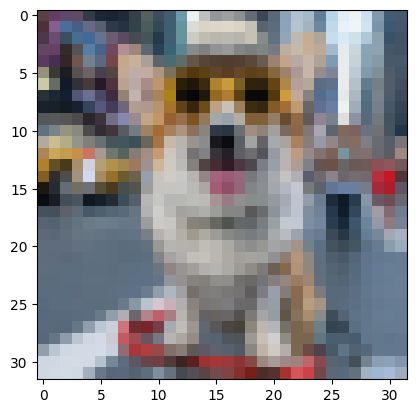

In [9]:
plt.imshow(reverse_transform(torch_image))

In [10]:
t = torch.tensor([0,1,2,3,4])
batch_images = torch.stack([torch_image] * 5)
noisy_images, _ = forward_diffusion(batch_images, t)

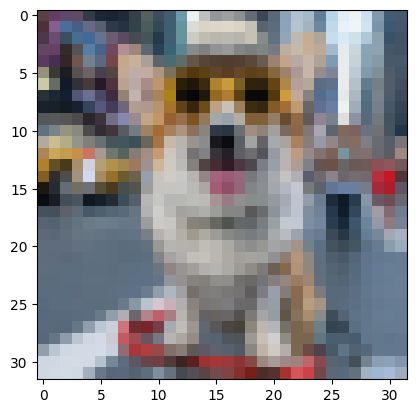

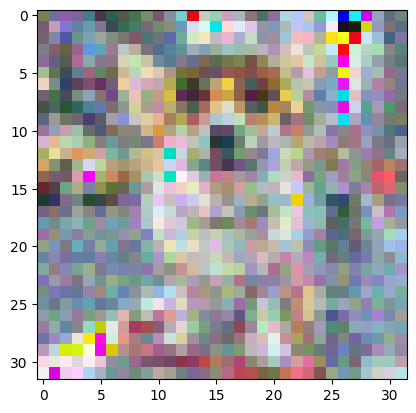

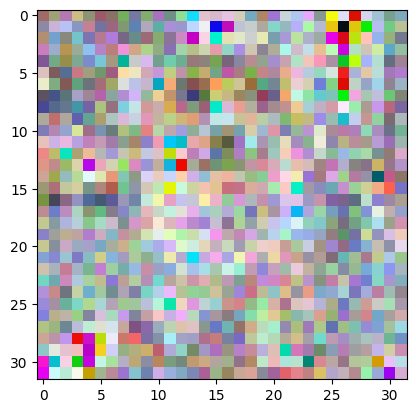

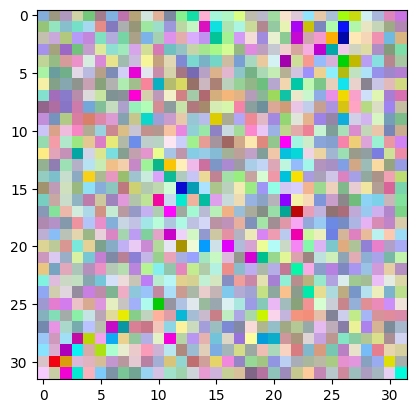

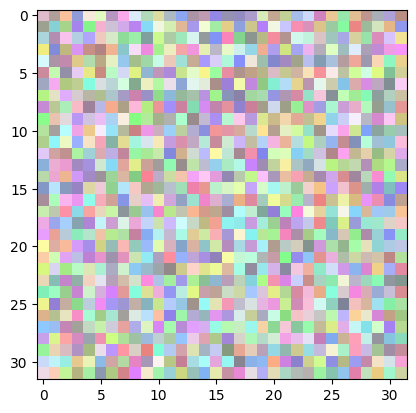

In [11]:
for img in noisy_images:
  plt.imshow(reverse_transform(img))
  plt.show()

# **Again, we clean up the code:**

In [12]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import segmentation_models_pytorch as smp
unet = smp.Unet()
import segmentation_models_pytorch as smp

In [14]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL
import segmentation_models_pytorch as smp
unet = smp.Unet()


In [15]:
device = 'cpu'

In [16]:
def get_sample_image()-> PIL.Image.Image:
    url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZmJy3aSZ1Ix573d2MlJXQowLCLQyIUsPdniOJ7rBsgG4XJb04g9ZFA9MhxYvckeKkVmo&usqp=CAU'
    filename = 'racoon.jpg'
    urllib.request.urlretrieve(url, filename)
    return PIL.Image.open(filename)

In [17]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]


        """
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns
        the denoised image.
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance


    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)